In [1]:
import preprocessor

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

In [3]:
FIGURE_SIZE = (12, 6)

In [4]:
import os

TEST_IMG_OUTPUT_PATH = "test_images_output"

if not os.path.isdir(TEST_IMG_OUTPUT_PATH):
    os.mkdir(TEST_IMG_OUTPUT_PATH)
test_images = [ 'test_images/{}'.format(filename) for filename in os.listdir("test_images/") ]
test_images.sort()
print(test_images)

['test_images/challenge01.jpg', 'test_images/challenge02.jpg', 'test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


In [5]:
from camera_calibrator import CameraCalibrator, Undistorter



In [6]:
calibrator = CameraCalibrator(9, 6)

calibrator.calibrate()

Searching for calibration images at  camera_cal/*.jpg
20 files found for calibration.
Crunching camera_cal/calibration16.jpg ...
Crunching camera_cal/calibration8.jpg ...
Crunching camera_cal/calibration3.jpg ...
Crunching camera_cal/calibration17.jpg ...
Crunching camera_cal/calibration2.jpg ...
Crunching camera_cal/calibration7.jpg ...
Crunching camera_cal/calibration15.jpg ...
Crunching camera_cal/calibration1.jpg ...
Crunching camera_cal/calibration12.jpg ...
Crunching camera_cal/calibration6.jpg ...
Crunching camera_cal/calibration19.jpg ...
Crunching camera_cal/calibration5.jpg ...
Crunching camera_cal/calibration11.jpg ...
Crunching camera_cal/calibration14.jpg ...
Crunching camera_cal/calibration10.jpg ...
Crunching camera_cal/calibration13.jpg ...
Crunching camera_cal/calibration18.jpg ...
Crunching camera_cal/calibration9.jpg ...
Crunching camera_cal/calibration4.jpg ...
Crunching camera_cal/calibration20.jpg ...
Calibration successful


In [7]:
mtx, dist = calibrator.get_calibration_data()
print(mtx, dist, calibrator.get_shape())
undistorter = Undistorter(mtx, dist, calibrator.get_shape())

[[1.15777930e+03 0.00000000e+00 6.67111054e+02]
 [0.00000000e+00 1.15282291e+03 3.86128938e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] [[-0.24688775 -0.02373133 -0.00109842  0.00035108 -0.00258571]] (720, 1280)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


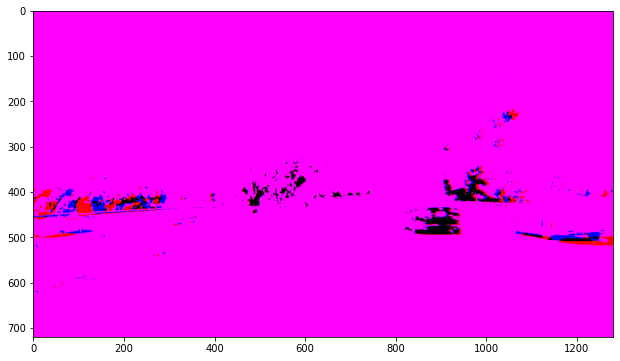

In [8]:
#
#    Calibrator and Undistorter validation
#

img = cv2.imread(test_images[4])
distorted = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
undistorted = undistorter.undistort(distorted)

out_shape = [undistorted.shape[0], undistorted.shape[1], 3]
output = np.zeros(out_shape)
output[:,:,0] = cv2.resize(distorted, (out_shape[1], out_shape[0]))//16
output[:,:,2] = undistorted//16
plt.figure(figsize=FIGURE_SIZE)
plt.imshow(output)

In [9]:
def plot_bgr(img):
    """ A helper for plotting a BGR image with matplotlib """
    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def plot_gray(gray):
    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(gray, cmap='gray')

def plot_roi_on(img, roi):
    if len(img.shape) == 2:
        output = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        output = img.copy()
    roi_color = (255, 0, 255)
    thickness = 4
    cv2.polylines(output, [roi], True, roi_color, thickness)
    return output
    
def normalize(img):
    """ Expects a grayscale image """
    minimum = np.min(img)
    maximum = np.max(img)
    normalized = (((img + minimum) / (maximum - minimum) ) * 255).astype(np.uint8)
    return normalized
    
def to_hls_mix(img, frame_size=(1280, 720), save_output=False):
    """ Expects a cv2 mat (in BGR) as input """
    # The idea is to mix Lum and Sat channels to improve lane lines visibility
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    lum = hls[:,:,1].astype(np.int16)
    sat = hls[:,:,2].astype(np.int16)
    mix = (lum * 0.5) + (sat * 0.6 )
    output = normalize(mix)
    if output.shape != frame_size:
        output = cv2.resize(output, frame_size)
    if save_output :
        cv2.imwrite(os.path.join(TEST_IMG_OUTPUT_PATH, "stage_01.jpg"), output)
    return output

def to_lumgrad_sat_mix(img, save_output=False):
    """ Expects a cv2 mat (in BGR) as input """
    # The idea is to mix Lum and Sat channels to improve lane lines visibility
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    lum = cv2.medianBlur(hls[:,:,1].astype(np.int16), 3)
    sat = cv2.medianBlur(hls[:,:,2].astype(np.int16), 3)

    #plot_gray(normalize(lum))
    lumgrad = normalize(np.absolute(cv2.Sobel(lum, cv2.CV_64F, 1, 0, ksize=5)))*4
    #lumgrad = normalize(np.absolute(cv2.Laplacian(lum, cv2.CV_64F)))*4
    satgrad = normalize(np.absolute(cv2.Sobel(sat, cv2.CV_64F, 1, 0, ksize=5)))*4
    #satgrad = normalize(np.absolute(cv2.Laplacian(sat, cv2.CV_64F)))*4
    plot_gray(lumgrad)
    plot_gray(satgrad)

    mix = (lumgrad) + (satgrad) + (lum//4) + (sat//4)
    return mix
    
def to_high_contrast(img, frame_size=(1280, 720), save_output=False):
    """ Expects a cv2 mat (in BGR) as input """
    # The idea is to mix Lum and Sat channels to improve lane lines visibility
    height, width = img.shape[:2]
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    lum = hls[:,:,1].astype(np.int16)
    sat = hls[:,:,2].astype(np.int16)
    
    lum_thr = 100
    min_lum = np.maximum(0, lum - lum_thr)
    lum_part = normalize(np.power(min_lum, 2))
    
    sat_thr = sat.mean()
    min_sat = np.maximum(0, sat - sat_thr)
    sat_part = np.minimum(255, min_sat + 100)
    mix = np.maximum(sat_part, lum_part)
    output = np.maximum(0, np.minimum(mix, 255)).astype(np.uint8)
    return output

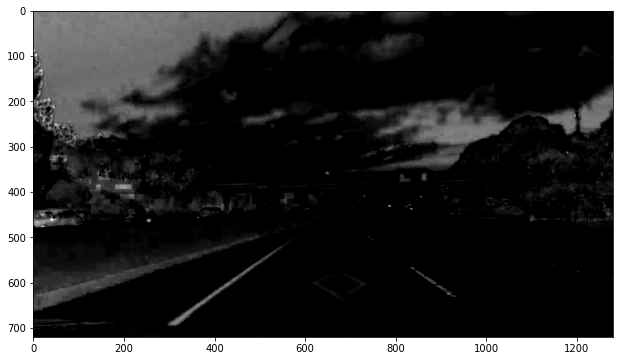

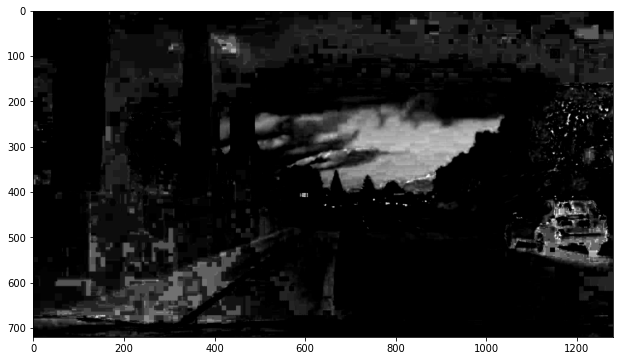

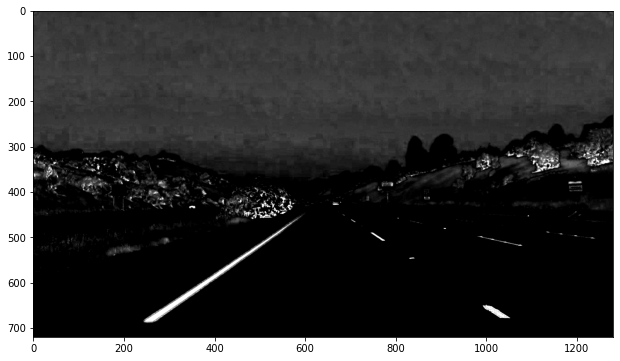

In [10]:
# Validate the HLS pipeline
for test_img in test_images[0:3]:
    img = cv2.resize(cv2.imread(test_img), (1280, 720))
    st_1 = to_high_contrast(img)
    #plot_bgr(img)
    plot_gray(st_1)

In [11]:
# Good: gray_input, blur_radius=5, sobel_kernel=17 angle_range=(0.7, 1.3), magnitude_range=(75,255)
# TRY; gray_input, blur_radius=3, sobel_kernel=11 angle_range=(0.85, 1.15), magnitude_range=(30,255)
ANGLE_RANGE=(0.6, 1.15)
def amplify_lane_pixels(gray_input, blur_radius=3, sobel_kernel=15
                        , angle_range=ANGLE_RANGE, magnitude_range=(30,255), save_output=False):
    """ Finds and amplifies pixels that are looking as lane line markings"""
    # Either medianBlur or GaussianBlur
    # blurred = cv2.medianBlur(gray_input, blur_radius)
    blurred = cv2.GaussianBlur(gray_input, (blur_radius, blur_radius), 0)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Calculate the direction of the gradient and select only pixels
    # near edges of the matching slope (to the 'angle_range' in radians)
    angles = np.arctan2(abs_sobely, abs_sobelx)
    (angle_min, angle_max) = angle_range
    direction = np.zeros_like(angles)
    direction[(angles >= angle_min) & (angles <= angle_max)] = 1
    # plot_gray(direction)
    # Calculate magnitude of the gradient
    mag_raw = normalize(np.sqrt(np.power(abs_sobelx, 2) + np.power(abs_sobely, 2)))
    min_magnitude, max_magnitude = magnitude_range;
    magnitude = np.zeros_like(blurred)
    magnitude[(mag_raw > min_magnitude) & (mag_raw < max_magnitude)] = 1
    # plot_gray(magnitude)
    # Combining thresholds
    combined = np.zeros_like(blurred)
    combined[((magnitude == 1) & (direction == 1))] = 1
    #combined = magnitude + direction
    # plot_gray(combined)
    dilate_kernel = np.ones((3,3),np.uint8)
    erode_kernel = np.ones((3,3),np.uint8)
    #output = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, dilate_kernel)
    output = combined
    if save_output :
        cv2.imwrite(os.path.join(TEST_IMG_OUTPUT_PATH, "stage_02.jpg"), normalize(output))
    return output

def upper_point(lower_point, angle, height, length=250):
    ''' Returns the second point at given length and angle from a lower_point '''
    ''' The point is always higher (thus the name upper_point) '''
    assert(len(lower_point) == 2)
    x, y = lower_point
    y = height - y
    upper_x = x + length * np.cos(angle);
    upper_y = height - (y + length * np.sin(angle));

    return (int(upper_x), int(upper_y))

def visualize_angle_range(img, angle_range=(0.8, 1.2), total_lines=20,
                          side_offset=0.4,
                          bottom_offset=0.25,
                          color=[255,0,255], thickness=2):
    ''' Plots a two star-like structures, displaying the slope range '''
    height, width = img.shape[:2]
    side_margin = int(width * side_offset)
    bottom_margin = int(height * bottom_offset)
    angles = np.linspace(angle_range[0], angle_range[1], total_lines)
    left_origin = (side_margin, height - bottom_margin)
    right_origin = (width - side_margin, height - bottom_margin)
    left_lines = [[left_origin, upper_point(left_origin, angle, height)] for angle in angles]
    right_lines = [[right_origin, upper_point(right_origin, (-1)*angle, height)] for angle in angles]


    for line in left_lines:
        cv2.line(img, line[0], line[1], color, thickness)
    for line in right_lines:
        cv2.line(img, line[0], line[1], color, thickness)
    return img
    
    

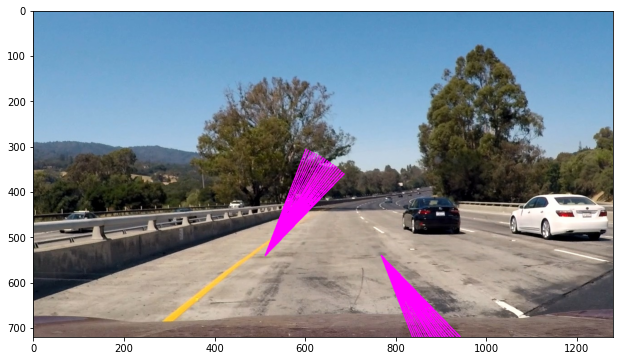

In [12]:
# Validate angle range on an image
for test_img in test_images[4:5]:
    img = cv2.imread(test_img)
    plot_bgr(visualize_angle_range(img))
    

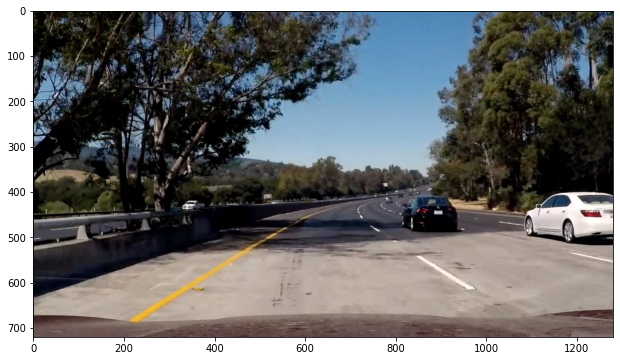

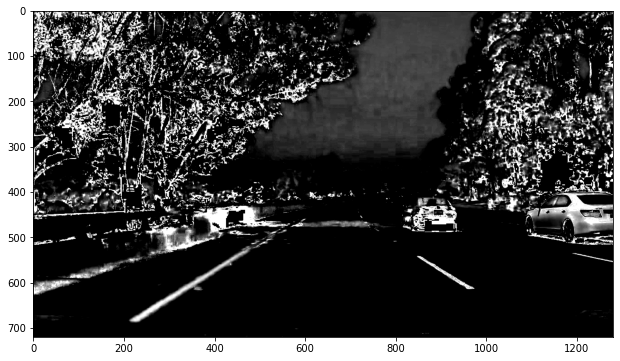

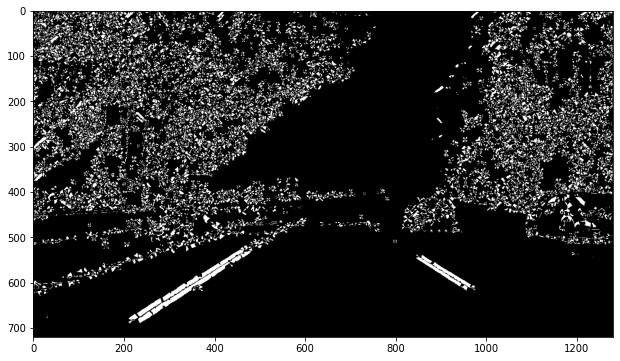

In [13]:
# Validate the HLS pipeline
for test_img in test_images[-2:-1]:
    img = cv2.resize(cv2.imread(test_img), (1280, 720))
    st_1 = to_high_contrast(img)
    st_2 = normalize(amplify_lane_pixels(st_1))
    plot_bgr(img)
    plot_gray(st_1)
    plot_gray(st_2)

In [28]:
# TODO: warp transform here.

# TODO: encapsulate the default ROI to a class.
''' OLD roi for a cropped undistortion
h_center = 600
h_offset = 20
top = 370
bottom = 620 #630
left = 100
right = 1100'''
h_center = 640
h_offset = 65
top = 460#450
bottom = 690
left = 200
right = 1080
CAMERA_ROI = np.array([[left, bottom],
                [h_center - h_offset, top],
                [h_center + h_offset, top],
                [right, bottom]]
               , np.int32)

birds_top = 0
birds_bottom = 720
birds_left = left +50
birds_right = right -50
BIRD_ROI =  np.float32([[birds_left, birds_bottom],
                       [birds_left, birds_top],
                       [birds_right, birds_top],
                       [birds_right, birds_bottom]])

class Bird():
    def __init__(self, roi, camera_roi=CAMERA_ROI):
        # ROIs are expected to be np.float32 arrays of shape (4, 2)
        # describing a region starting from the bottom left point clockwise
        self.roi = roi
        self.camera_roi = camera_roi
        self.M = cv2.getPerspectiveTransform(camera_roi, roi)
        self.invM = cv2.getPerspectiveTransform(roi, camera_roi)
    
    def from_above(self, img):
        return cv2.warpPerspective(img, self.M, 
                                   (img.shape[1], img.shape[0]),
                                   flags=cv2.INTER_LINEAR)
    
    def to_road(self, img):
        return cv2.warpPerspective(img, self.invM, 
                                   (img.shape[1], img.shape[0]),
                                   flags=cv2.INTER_LINEAR)

def to_birdseye(img, roi=CAMERA_ROI):
    """ Expects a trapezoidal ROI to start from the bottom left point """
    """ Expects an undistorted input image """

    M = cv2.getPerspectiveTransform(roi.astype(np.float32), birds_roi)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

bird = Bird(BIRD_ROI, CAMERA_ROI.astype(np.float32))

    

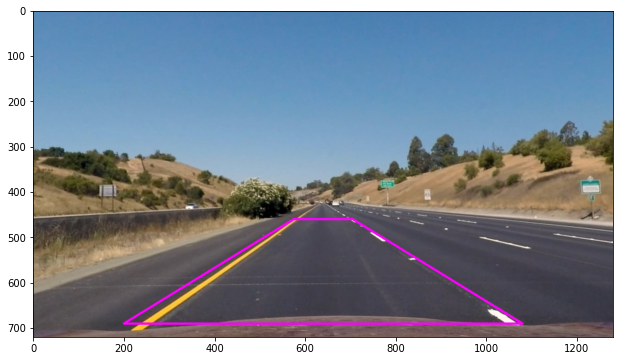

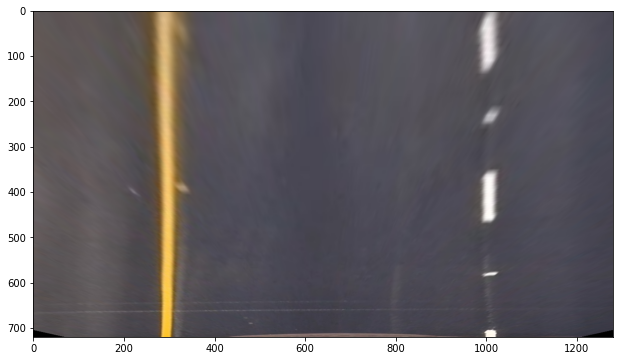

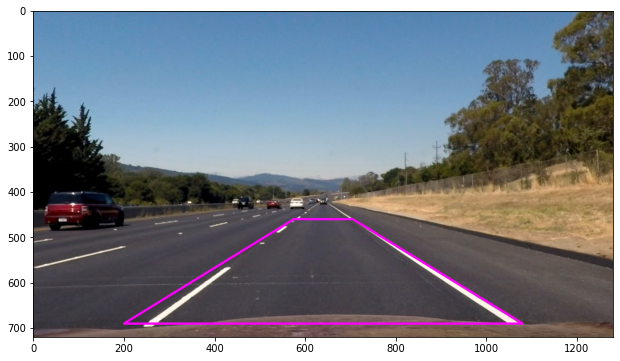

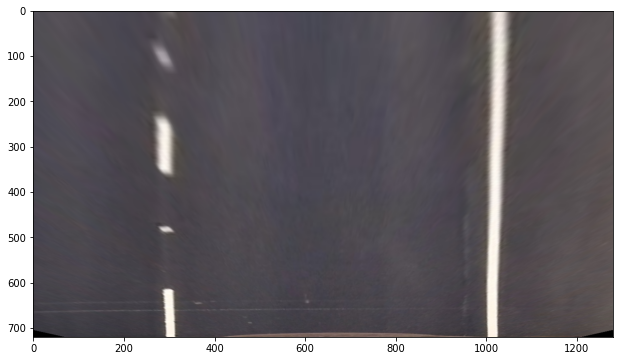

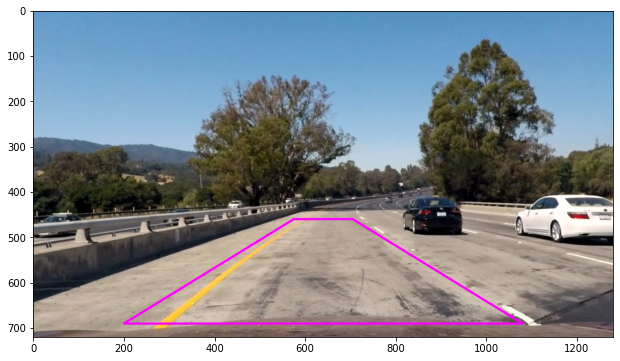

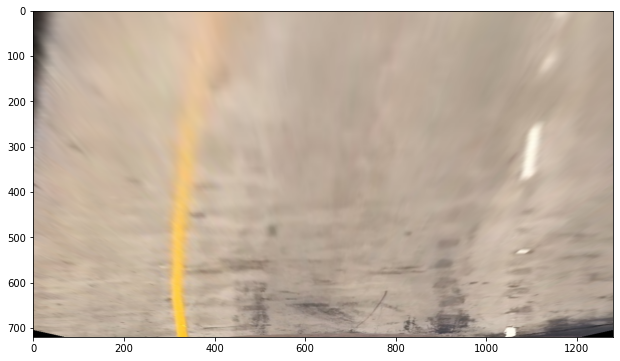

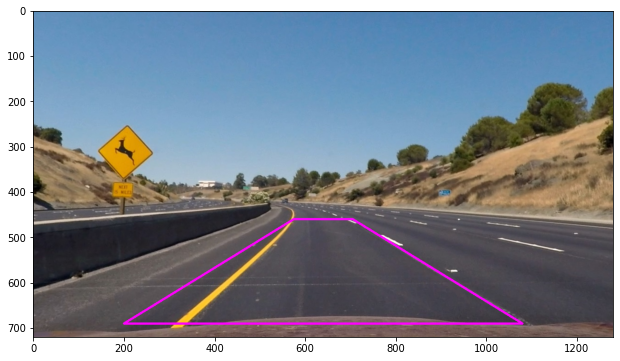

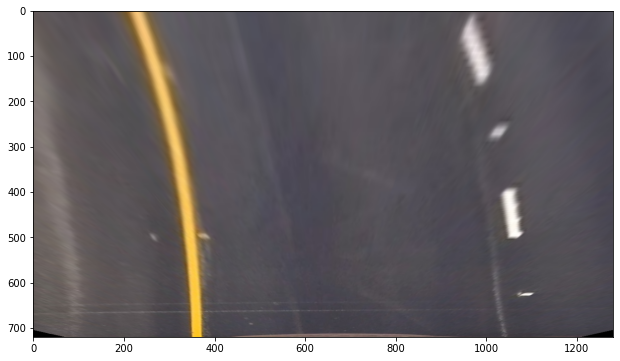

In [30]:
# Validate the warp transform
# https://docs.opencv.org/master/dc/da5/tutorial_py_drawing_functions.html
for test_img in test_images[2:6]:
    #break
    img = cv2.imread(test_img)
    
    fpv = undistorter.undistort(img)
    fpv_roi = plot_roi_on(fpv, CAMERA_ROI)
        
    plot_bgr(fpv_roi)
    
    birds_eye = bird.from_above(fpv)

    plot_bgr(birds_eye)
    

In [31]:
def evaluate_poly2(poly, y):
    ''' Evaluate a 2-grade polynomial '''
    return poly[0]*y*y + poly[1]*y + poly[2]

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin 
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix: 
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

def plot_lane_curves(lane_img, left_fit, right_fit, color=[0,255,255], thickness=4):
    # Generate x and y values for plotting
    ploty = np.linspace(0, lane_img.shape[0]-1, lane_img.shape[0] // 72 )
    left_curve = np.int32(list(zip(evaluate_poly2(left_fit, ploty), ploty)))
    right_curve = np.int32(list(zip(evaluate_poly2(right_fit, ploty), ploty)))
    out_img = cv2.polylines(lane_img, [left_curve, right_curve], False, color, thickness)
    return out_img

def plot_lane_poly_on(lane_img, left_fit, right_fit, color=[0,255,0]):
    # Generate x and y values for plotting
    ploty = np.linspace(0, lane_img.shape[0]-1, 10)
    left_curve = np.int32(list(zip(evaluate_poly2(left_fit, ploty), ploty)))
    right_curve = np.int32(list(zip(evaluate_poly2(right_fit, ploty), ploty)))[::-1]
    points = np.append(left_curve, right_curve, axis=0)
    cv2.fillPoly(lane_img, [points], color)

In [32]:
class LaneLine():
    def __init__(self, avg_depth=8):
        self.avg_depth = avg_depth
        # Poly coefficients. averaged during last N calls
        self.avg_fit = None
        self.isValid = False
        # Lane curvature radius in meters
        self.radius_m = 10e3
        # Distance in meters of vehicle center from the line
        # (assuming the car is centered and the lane width is 3.75 meters)
        self.line_base_pos_mm = 3750./2
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
    
    def update(self, poly, x_pixels=None, y_pixels=None):
        if x_pixels is not None:
            self.x_pixels = x_pixels
        if y_pixels is not None:
            self.y_pixels = y_pixels
        if self.avg_fit is None:
            self.avg_fit = poly
        else:
            # Improvement of a naive averaging: if the diff is huge,
            # do a more conservative averaging. 
            # TODO: probably, not every member is equally important.
            diff = np.absolute(self.avg_fit - poly)
            weighted_diff = diff[0]**2 + diff[1]
            dynamic_depth = int(max(weighted_diff, self.avg_depth))
            self.avg_fit = (self.avg_fit * (dynamic_depth - 1) + poly) / dynamic_depth
        
    def get_fit(self):
        return self.avg_fit

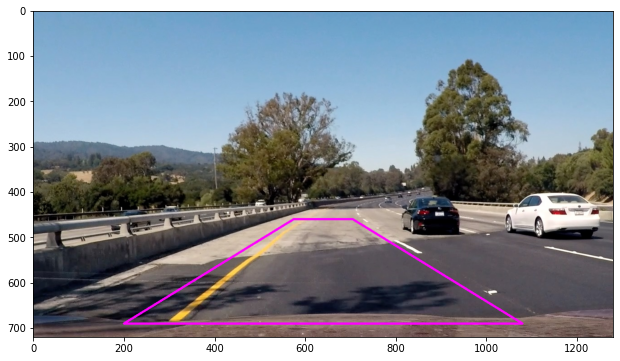

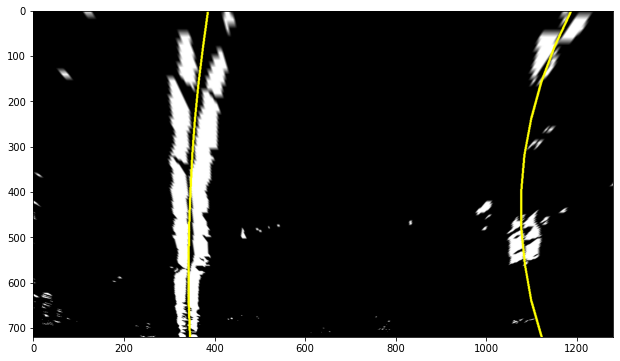

In [33]:
# Validate lane pixel finding via sliding window
for test_img in test_images[7:8]:
    img = cv2.imread(test_img)
    plot_bgr(plot_roi_on(img, CAMERA_ROI))
    hls = to_hls_mix(img)
    fpv = undistorter.undistort(hls)
    highlight = normalize(amplify_lane_pixels(fpv))
    birds_eye = bird.from_above(highlight)
    lfit, rfit = fit_polynomial(birds_eye)
    found = plot_lane_curves(cv2.cvtColor(birds_eye, cv2.COLOR_GRAY2BGR), lfit, rfit)
    #plot_lane_poly_on(found, lfit, rfit)
    plot_bgr(found)

In [34]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [35]:
# Note: an Undistorter instance is necessary

rlane = LaneLine(20)
llane = LaneLine(20)

def process_frame(frame):
    global bayes_buffer
    bcoeff = 12
    """ Expects an RGB frame as input """
    height, width, _ = frame.shape
    stage_0_sample = to_high_contrast(frame)
    stage_1_sample = normalize(amplify_lane_pixels(stage_0_sample))
    stage_2_sample = bird.from_above(undistorter.undistort(stage_1_sample))
    lfit, rfit = fit_polynomial(stage_2_sample)
    llane.update(lfit); rlane.update(rfit);
    stage_3_sample = plot_lane_curves(cv2.cvtColor(stage_2_sample, cv2.COLOR_GRAY2BGR)
                                      , llane.get_fit(), rlane.get_fit())
    tile_00 = cv2.cvtColor(cv2.resize(stage_0_sample, (width//2, height//2)), cv2.COLOR_GRAY2BGR)
    tile_01 = cv2.cvtColor(cv2.resize(stage_1_sample, (width//2, height//2)), cv2.COLOR_GRAY2BGR)
    tile_11 = cv2.resize(stage_3_sample, (width//2, height//2))
    
    road_poly_from_above = np.zeros_like(frame)
    plot_lane_poly_on(road_poly_from_above, llane.get_fit(), rlane.get_fit())
    lane_poly = bird.to_road(road_poly_from_above)
    tile_10 = cv2.resize(np.maximum(frame, lane_poly), (width//2, height//2))
    
    output = np.zeros_like(frame)
    output [:height//2, :width//2] = tile_00
    output [:height//2, width//2:] = tile_01
    output [height//2:, :width//2] = tile_10
    output [height//2:, width//2:] = tile_11
    return output
        

In [36]:
test_video_output = 'test_video_output/test_video.mp4'
#input_video = 'harder_challenge_video.mp4'
#input_video = 'challenge_video.mp4'
input_video = 'project_video.mp4'

clip1 = VideoFileClip(input_video).subclip(2,15)#48)
#clip1 = VideoFileClip(input_video)
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(test_video_output, audio=False)

t:   1%|          | 2/325 [00:00<00:22, 14.18it/s, now=None]

Moviepy - Building video test_video_output/test_video.mp4.
Moviepy - Writing video test_video_output/test_video.mp4



Moviepy - Done !
Moviepy - video ready test_video_output/test_video.mp4
CPU times: user 1min 30s, sys: 6.43 s, total: 1min 37s
Wall time: 53.7 s
